In [4]:
import torch
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
from utils import setup_data_loaders, get_sample
from dataset.dataset import BackgroundDataset
import cv2
import numpy as np

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Plot sample

In [3]:
image, mask, matting, image_input, mask_input = get_sample("37", split_set="validation", device=DEVICE, go_parent_folder=True, width=384, height=512)

In [4]:
def blur_image_background(image, mask, threshold):
  """
  Aplicar la máscara a una imagen.

  La máscara tiene valores desde 0.0 hasta 1.0.

  Devuelve una nueva imagen donde para cada píxel se obtiene el píxel correspondiente
  de la máscara:
    - Si el píxel de la máscara > threshold: se conserva el píxel de la imagen original.
    - Si el píxel de la máscara <= threshold: el píxel de la imagen original se desenfoca.
  """
  blurred_image = cv2.blur(src=image, ksize=(75,75))

  return np.where(mask > threshold, image, blurred_image)

In [5]:
def replace_background_by_image(image, mask, threshold, background_image):
    """
    Apply a mask to an image.

    The mask values range from 0.0 to 1.0.

    Returns a new image where for each pixel:
      - If the mask pixel > threshold: the original image pixel is retained.
      - If the mask pixel <= threshold: the pixel is replaced with the Mars background.
    """
    # Ensure Mars background matches the image size
    background_image_resized = cv2.resize(background_image, (image.shape[1], image.shape[0]))

    # Create a new image with Mars background where the mask is below the threshold
    return np.where(mask[:, :, np.newaxis] > threshold, image, background_image_resized)

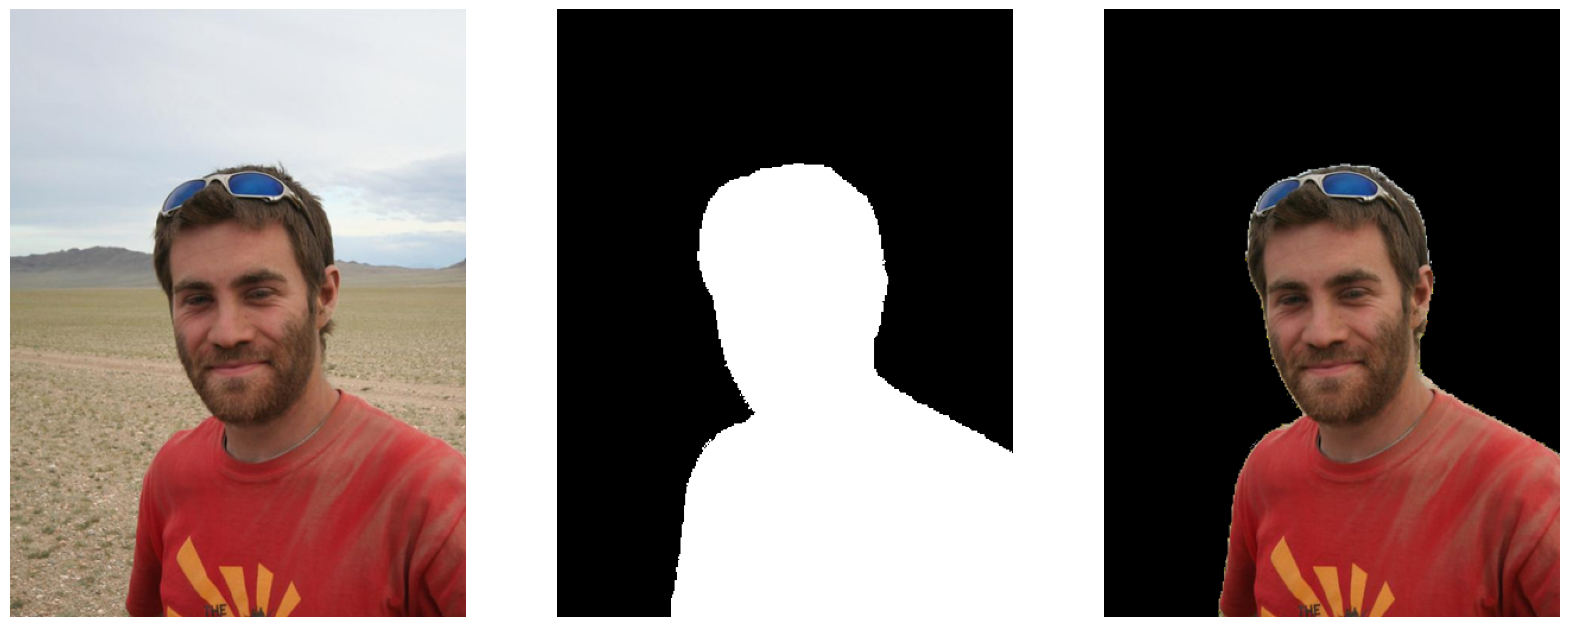

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 3)
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
ax[2].imshow(matting)
ax[2].axis("off")
plt.show()

In [13]:
image_with_blur = blur_image_background(image, mask[:,:,np.newaxis], 0.5)

In [20]:
plt.imshow(image_with_blur)
plt.axis("off")
plt.savefig("output_image.png", bbox_inches='tight', pad_inches=0)  # Saves the image without white borders
plt.close()

In [23]:
mars_image = cv2.imread("mars.jpg")
mars_image = cv2.cvtColor(mars_image, cv2.COLOR_BGR2RGB)
image_diff_background = replace_background_by_image(image, mask, 0.5, mars_image)

In [24]:
plt.imshow(image_diff_background)
plt.axis("off")
plt.savefig("output_image_mars.png", bbox_inches='tight', pad_inches=0)  # Saves the image without white borders
plt.close()

Print the dimensions of an image and a mask:

In [17]:
# Print the dimensions of an image and a mask:
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: (512, 384, 3)
Mask shape: (512, 384)


## Dataset

In [18]:
DATA_FOLDER = os.path.join("..", "data")
    
train_dataset = BackgroundDataset(DATA_FOLDER, "training", True, image_height=512, image_width=384)

# print the shape of a random image and its mask
image, mask = train_dataset[1]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: torch.Size([3, 512, 384])
Mask shape: torch.Size([1, 512, 384])


In [19]:
image = image.permute(1, 2, 0)
mask = mask.squeeze(0)

In [20]:
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: torch.Size([512, 384, 3])
Mask shape: torch.Size([512, 384])


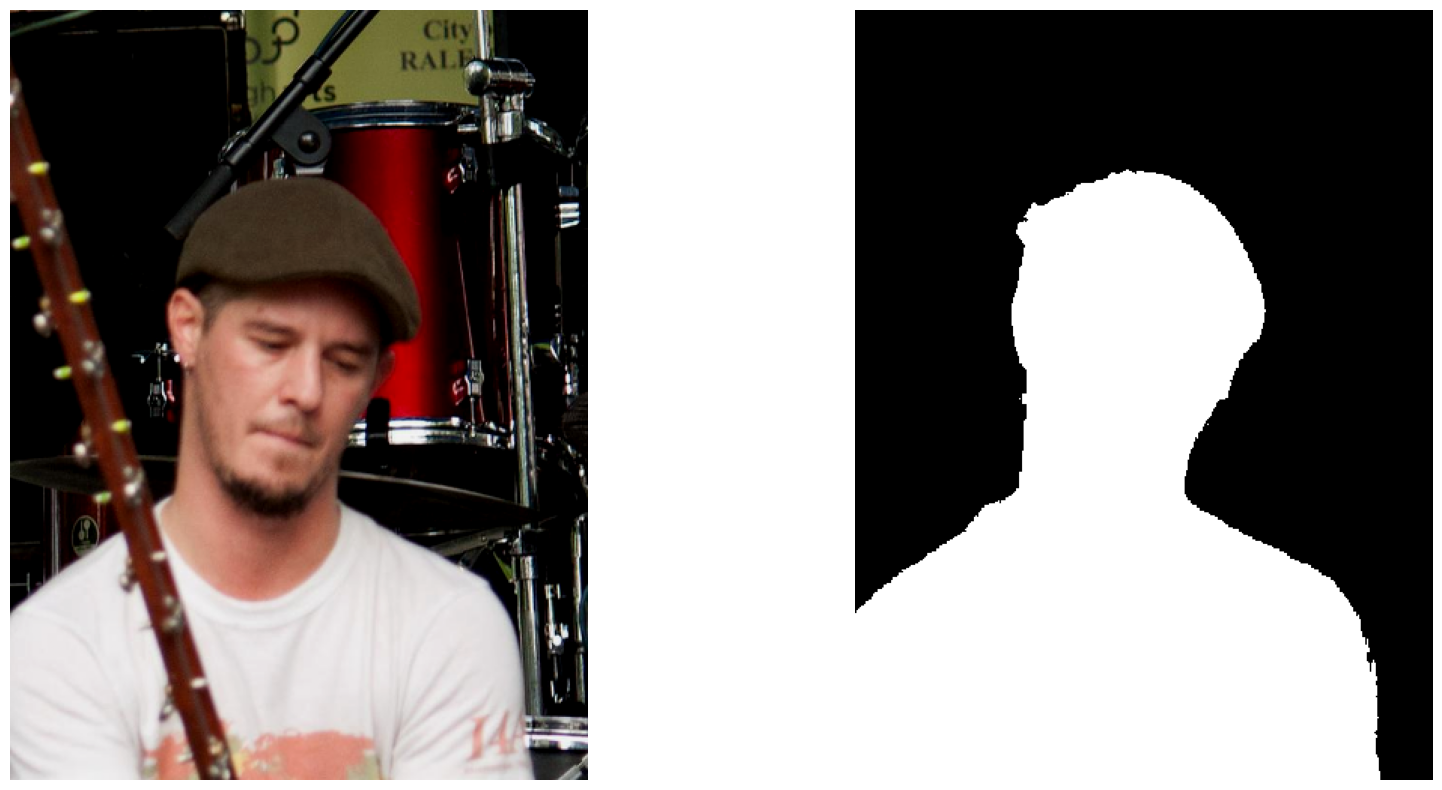

In [21]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
plt.show()